In [ ]:
!pip install transformers
!pip install pytorch_lightning

     |████████████████████████████████| 4.2 MB 4.1 MB/s 
     |████████████████████████████████| 6.6 MB 57.5 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 596 kB 72.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 584 kB 4.4 MB/s 
     |████████████████████████████████| 140 kB 38.2 MB/s 
     |████████████████████████████████| 409 kB 42.7 MB/s 
     |████████████████████████████████| 1.1 MB 48.2 MB/s 
     |████████████████████████████████| 144 kB 63.6 MB/s 
     |████████████████████████████████| 271 kB 60.6 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

#handling html data
from bs4 import BeautifulSoup
from wordcloud import WordCloud

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 300
LR = 2e-05

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Reading the data

In [1]:
import pandas as pd
# file_name = 'export.csv' 
df = pd.read_csv(file_path, nrows=5000)
df.head() # print the first 5 rows

NameError: ignored

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CELEX        5000 non-null   object
 1   VOC_CONCEPT  5000 non-null   object
 2   Text         5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


# EDA

In [ ]:
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [ ]:
df['num_labs'] = df.apply(lambda x: len(str(x[1]).split('|')), axis=1)
df['text_size'] = df.apply(lambda x: len(str(x[2])), axis=1)
df['num_words'] = df.apply(lambda x: len(str(x[2]).split()), axis=1)
df['labels'] = df.apply(lambda x: str(x[1]).split('|'), axis=1)
df["inp_text"]= df['Text'].apply(pre_process)

df

,CELEX,VOC_CONCEPT,Text,num_labs,text_size,num_words,labels,inp_text
0,21972A0722(03),Switzerland|trading operation|customs duties|t...,21972A0722(03) Agreement between the European ...,6,193567,33534,"[Switzerland, trading operation, customs dutie...",a agreement between the european economic comm...
1,21980D1231(03),Greece|tariff policy|agreement (EU)|accession ...,21980D1231(03) Decision No 3/80 of the EEC-Ice...,6,4019,649,"[Greece, tariff policy, agreement (EU), access...",d decision no of the eec iceland joint committ...
2,21981A0710(02),Hungary|trade agreement (EU)|goatmeat|sheepmea...,21981A0710(02) Exchange of letters between the...,5,6356,1038,"[Hungary, trade agreement (EU), goatmeat, shee...",a exchange of letters between the european eco...
3,21986A1115(03),trade agreement|Portugal|protocol to an agreem...,15.11.1986 EN Official Journal of the European...,7,101001,18241,"[trade agreement, Portugal, protocol to an agr...",en official journal of the european communitie...
4,21987A0720(02),protocol to an agreement|customs harmonisation...,20.7.1987 EN Official Journal of the European ...,6,2237,359,"[protocol to an agreement, customs harmonisati...",en official journal of the european communitie...
...,...,...,...,...,...,...,...,...
4995,32011R1052,import price|fruit|import (EU)|vegetable|commo...,21.10.2011 EN Official Journal of the European...,5,2434,422,"[import price, fruit, import (EU), vegetable, ...",en official journal of the european union l co...
4996,32011R1200,Combined Nomenclature|mechanical equipment,23.11.2011 EN Official Journal of the European...,2,5092,847,"[Combined Nomenclature, mechanical equipment]",en official journal of the european union l co...
4997,32011R1297,designation of origin|product designation|oliv...,14.12.2011 EN Official Journal of the European...,4,2592,411,"[designation of origin, product designation, o...",en official journal of the european union l co...
4998,32011R1338,cooperation policy|developing countries|EU fin...,30.12.2011 EN Official Journal of the European...,4,28812,4369,"[cooperation policy, developing countries, EU ...",en official journal of the european union l re...


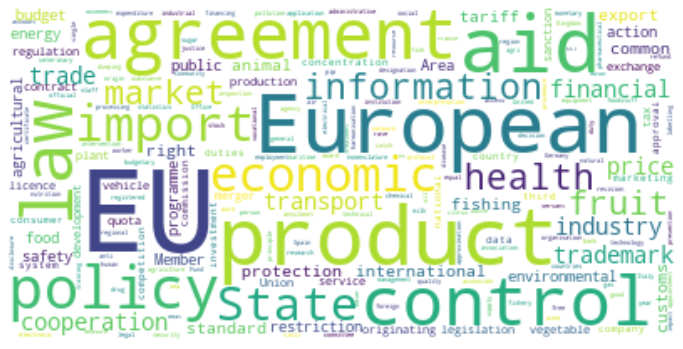

In [ ]:
word_cloud_text = ""
for text in df['labels'].values:
    word_cloud_text+=" ".join(text)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_text)
plt.figure(figsize = (12, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

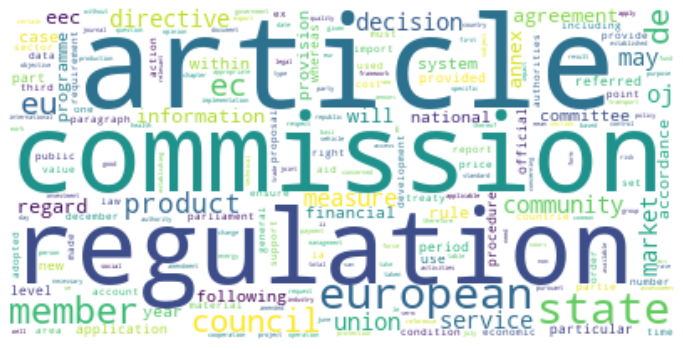

In [ ]:
word_cloud_text = ""
for text in df['inp_text'].values:
    word_cloud_text+=text
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_text)
plt.figure(figsize = (12, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

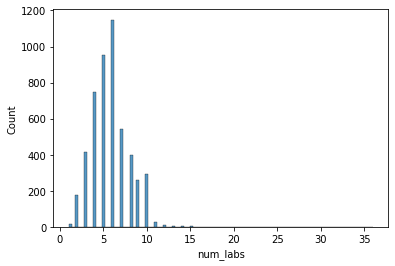

In [ ]:
sns.histplot(data = df, x='num_labs')
plt.show()

In [ ]:
unique_labels = set()
for label in df['labels']:
    unique_labels.update(label)
unique_labels = sorted(list(unique_labels))
print(len(unique_labels))
unique_labels

3642


['ACP countries',
 'ACP-EU Committee of Ambassadors',
 'ACP-EU Convention',
 'ACP-EU Joint Assembly',
 'ACP-EU relationship',
 'AIDS',
 'Abruzzi',
 'Aegean Islands',
 'Afghanistan',
 'Africa',
 'African Union',
 'Albania',
 'Alentejo',
 'Algeria',
 'Alpine Region',
 'Alsace',
 'America',
 'Andalusia',
 'Andean Community',
 'Andorra',
 'Angola',
 'Apulia',
 'Aquitaine',
 'Argentina',
 'Armenia',
 'Asia',
 'Association Council (EU)',
 'Atlantic Ocean',
 'Attica',
 'Australia',
 'Austria',
 'Autonomous Province of Trento',
 'Auvergne',
 'Azerbaijan',
 'Azores',
 'Baden-Württemberg',
 'Bahamas',
 'Bahrain',
 'Balearic Islands',
 'Baltic Sea',
 'Baltic States',
 'Bangladesh',
 'Basque Country',
 'Bavaria',
 'Belarus',
 'Belgium',
 'Belize',
 'Berlin',
 'Black Sea',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botosani',
 'Brandenburg',
 'Brazil',
 'Brittany',
 'Brussels region',
 'Buddhism',
 'Bulgaria',
 'Burgas region',
 'Burgundy',
 'Burma/Myanmar',
 'Burundi',
 'CCT duties',
 'CEPOL',
 'CFS

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])
y.shape

(5000, 3642)

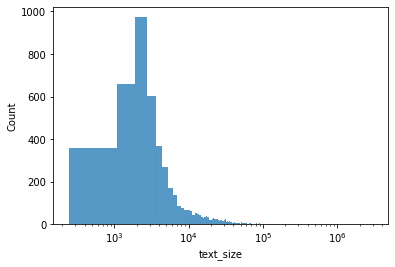

In [ ]:
sns.histplot(data = df, x='text_size')
plt.xscale('log')
plt.show()

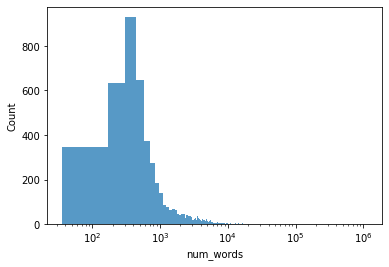

In [ ]:
sns.histplot(data = df, x='num_words')
plt.xscale('log')
plt.show()

In [ ]:
class QTagDataset(Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }
        

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=4,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def configure_optimizers(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=8)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 4)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 4)

In [ ]:
X = df['inp_text'].values

In [ ]:
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [ ]:
# we will use the BERT base model(the smaller one)
BERT_MODEL_NAME = "bert-base-cased"
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
  def __init__(self,n_classes=10,steps_per_epoch=None,n_epochs=3, lr=2e-5):
    super().__init__()

    self.bert=BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier=nn.Linear(self.bert.config.hidden_size,
n_classes) 
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.lr = lr
    self.criterion = nn.BCEWithLogitsLoss()
def forward(self,input_ids, attn_mask):
    output = self.bert(input_ids=input_ids,attention_mask=attn_mask)
    output = self.classifier(output.pooler_output)
          
    return output

In [ ]:
# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [ ]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test, BertTokenizer, BATCH_SIZE,MAX_LEN)
QTdata_module.configure_optimizers()

In [ ]:
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=y.shape[1], steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)
# Train the Classifier Model
trainer.fit(model, datamodule=QTdata_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MisconfigurationException: ignored

In [ ]:

column = df["VOC_CONCEPT"].tolist()
unique = {label for field in column for label in field.split("|")}
unique




{'dyestuff',
 'toxicology',
 'social impact',
 'surface water',
 'meat product',
 'sectoral agreement',
 'economic statistics',
 'property tax',
 'corporate social responsibility',
 'noise protection',
 'competition policy',
 'free movement of workers',
 'coordination of EMU policies',
 'business policy',
 'shareholding',
 'appeal',
 'scientific progress',
 'electric machinery',
 'advertising malpractice',
 'product safety',
 'cow',
 'financial risk',
 'employment service',
 'publication of a law',
 'plastics',
 'gas field',
 'cross-channel connection',
 'table wine',
 'declining industrial region',
 'non-profit organisation',
 'Ecuador',
 'polluter pays principle',
 'Central and Eastern Europe',
 'international arbitration',
 'originating product',
 'European security',
 'economic transition',
 'supplementary trade mechanism',
 'judicial proceedings',
 'Palestine',
 'CFSP',
 'industrial restructuring',
 'environmental monitoring',
 'recruitment',
 'plant health legislation',
 'tariff 

In [ ]:
len(unique)

3642

In [ ]:
df.loc[0, 'VOC_CONCEPT']

'Switzerland|trading operation|customs duties|trade agreement (EU)|economic relations|GATT'

In [ ]:
df.loc[2, 'Text']

"21981A0710(02) Exchange of letters between the European Economic Community and the People's Republic of Hungary on trade in the sheepmeat and goatmeat sector - exchange of letters on the consultations for which provision is made in point 9 of the exchange of letters - exchange of letters relevant to point 2 of the exchange of letters Official Journal L 150 , 06/06/1981 P. 0007 - 0015 EXCHANGE OF LETTERS between the European Economic Community and the People's Republic of Hungary on trade in the sheepmeat and goatmeat sector Letter No 1 Sir, I have the honour to refer to the negotiations recently undertaken between our respective delegations for the purpose of drawing up provisions concerning import into the European Economic Community of mutton, lamb and goatmeat, and live sheep and goats other than pure-bred breeding animals from Hungary ; in connexion with implementation by the Community of the common organization of the market in sheepmeat and goatmeat. During these negotiations wh

In [ ]:
df["New_VOC"] = df["VOC_CONCEPT"].str.split("|")

In [ ]:
df["New_VOC"]

0       [Switzerland, trading operation, customs dutie...
1       [Greece, tariff policy, agreement (EU), access...
2       [Hungary, trade agreement (EU), goatmeat, shee...
3       [trade agreement, Portugal, protocol to an agr...
4       [protocol to an agreement, customs harmonisati...
                              ...                        
4995    [import price, fruit, import (EU), vegetable, ...
4996        [Combined Nomenclature, mechanical equipment]
4997    [designation of origin, product designation, o...
4998    [cooperation policy, developing countries, EU ...
4999    [rules of procedure, EU office or agency, econ...
Name: New_VOC, Length: 5000, dtype: object

In [ ]:
df = df[['New_VOC','Text']]
df.head()

,New_VOC,Text
0,"[Switzerland, trading operation, customs dutie...",21972A0722(03) Agreement between the European ...
1,"[Greece, tariff policy, agreement (EU), access...",21980D1231(03) Decision No 3/80 of the EEC-Ice...
2,"[Hungary, trade agreement (EU), goatmeat, shee...",21981A0710(02) Exchange of letters between the...
3,"[trade agreement, Portugal, protocol to an agr...",15.11.1986 EN Official Journal of the European...
4,"[protocol to an agreement, customs harmonisati...",20.7.1987 EN Official Journal of the European ...


In [ ]:

column = df['New_VOC'].tolist()
unique = {label for field in column for label in field.split("|")}
unique



AttributeError: ignored

In [ ]:
# print("Amount of labels is: ", len(unique))
print("Amount of labels is: ", len(unique))

Amount of labels is:  3642


df.head()

In [ ]:
# row amount
len(df.index)

5000

In [ ]:
! pip install -q pytorch-lightning


In [ ]:
! pip install -q bs4
! pip install -q transformers

     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [ ]:
df["NEW_TEXT"]= df['Text'].apply(pre_process)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df["NEW_TEXT"]

0       a agreement between the european economic comm...
1       d decision no of the eec iceland joint committ...
2       a exchange of letters between the european eco...
3       en official journal of the european communitie...
4       en official journal of the european communitie...
                              ...                        
4995    en official journal of the european union l co...
4996    en official journal of the european union l co...
4997    en official journal of the european union l co...
4998    en official journal of the european union l re...
4999    en official journal of the european union c de...
Name: NEW_TEXT, Length: 5000, dtype: object

In [ ]:
df["New_VOC"] 

0       [Switzerland, trading operation, customs dutie...
1       [Greece, tariff policy, agreement (EU), access...
2       [Hungary, trade agreement (EU), goatmeat, shee...
3       [trade agreement, Portugal, protocol to an agr...
4       [protocol to an agreement, customs harmonisati...
                              ...                        
4995    [import price, fruit, import (EU), vegetable, ...
4996        [Combined Nomenclature, mechanical equipment]
4997    [designation of origin, product designation, o...
4998    [cooperation policy, developing countries, EU ...
4999    [rules of procedure, EU office or agency, econ...
Name: New_VOC, Length: 5000, dtype: object

In [ ]:
df["New_VOC"]

0       [Switzerland, trading operation, customs dutie...
1       [Greece, tariff policy, agreement (EU), access...
2       [Hungary, trade agreement (EU), goatmeat, shee...
3       [trade agreement, Portugal, protocol to an agr...
4       [protocol to an agreement, customs harmonisati...
                              ...                        
4995    [import price, fruit, import (EU), vegetable, ...
4996        [Combined Nomenclature, mechanical equipment]
4997    [designation of origin, product designation, o...
4998    [cooperation policy, developing countries, EU ...
4999    [rules of procedure, EU office or agency, econ...
Name: New_VOC, Length: 5000, dtype: object

In [ ]:
df1 = df[['New_VOC','NEW_TEXT']]
df1.head()

,New_VOC,NEW_TEXT
0,"[Switzerland, trading operation, customs dutie...",a agreement between the european economic comm...
1,"[Greece, tariff policy, agreement (EU), access...",d decision no of the eec iceland joint committ...
2,"[Hungary, trade agreement (EU), goatmeat, shee...",a exchange of letters between the european eco...
3,"[trade agreement, Portugal, protocol to an agr...",en official journal of the european communitie...
4,"[protocol to an agreement, customs harmonisati...",en official journal of the european communitie...


In [ ]:
# df.loc[1, 'NEW_TEXT']

In [ ]:
df1.shape


(5000, 2)

In [ ]:
columns_titles = ["NEW_TEXT","New_VOC"]
df1=df1.reindex(columns=columns_titles)
df1.head()

,NEW_TEXT,New_VOC
0,a agreement between the european economic comm...,"[Switzerland, trading operation, customs dutie..."
1,d decision no of the eec iceland joint committ...,"[Greece, tariff policy, agreement (EU), access..."
2,a exchange of letters between the european eco...,"[Hungary, trade agreement (EU), goatmeat, shee..."
3,en official journal of the european communitie...,"[trade agreement, Portugal, protocol to an agr..."
4,en official journal of the european communitie...,"[protocol to an agreement, customs harmonisati..."


In [ ]:
word_list = df1["New_VOC"][0]
type(word_list)

list

In [ ]:
df_count = pd.value_counts(np.hstack(df1['New_VOC']))

df_count


import                       204
originating product          180
merger control               178
economic concentration       178
State aid                    171
                            ... 
World Health Organisation      1
Taric                          1
Marshall Islands               1
Palau                          1
mechanical equipment           1
Length: 3642, dtype: int64

In [ ]:
df_count

import                       204
originating product          180
merger control               178
economic concentration       178
State aid                    171
                            ... 
World Health Organisation      1
Taric                          1
Marshall Islands               1
Palau                          1
mechanical equipment           1
Length: 3642, dtype: int64

In [ ]:
type(df_count)

pandas.core.series.Series

In [ ]:
 
headers =  ['Tags', 'Amount']
df_count.columns = headers
df_count

import                       204
originating product          180
merger control               178
economic concentration       178
State aid                    171
                            ... 
World Health Organisation      1
Taric                          1
Marshall Islands               1
Palau                          1
mechanical equipment           1
Length: 3642, dtype: int64

In [ ]:
df_frame = pd.DataFrame(df_count)

df_frame

,0
import,204
originating product,180
merger control,178
economic concentration,178
State aid,171
...,...
World Health Organisation,1
Taric,1
Marshall Islands,1
Palau,1


In [ ]:
list_tags = list(df_count.index.values)
top_tags = list_tags

In [ ]:
x=[] # To store the filtered clean_body values
y=[] # to store the corresponding tags
# Convert to list data type
lst_top_tags = top_tags

for i in range(len(df1['New_VOC'])):
    temp=[]
    for tag in df1['New_VOC'][i]:
        if tag in lst_top_tags:
            temp.append(tag)

    if(len(temp)>0):
        x.append(df1['NEW_TEXT'][i])
        y.append(temp)

In [ ]:
len(x)


5000

In [ ]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(5000, 3642)

In [ ]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[0 0 0 ... 0 0 0]
[('GATT', 'Switzerland', 'customs duties', 'economic relations', 'trade agreement (EU)', 'trading operation')]
['ACP countries' 'ACP-EU Committee of Ambassadors' 'ACP-EU Convention' ...
 'zoonosis' 'zootechnics' 'Žilina region']


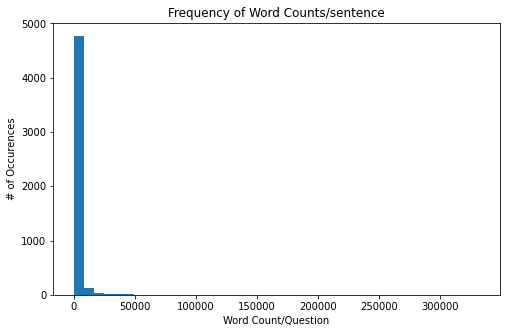

In [ ]:
# compute no. of words in each question
questions = x
word_cnt = [len(quest.split()) for quest in questions]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [ ]:
len(x_tr) ,len(x_val), len(x_test)


(3600, 900, 500)

In [ ]:
class QTagDataset(Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }
        

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=4,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=8)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 4)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 4)

In [ ]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
questions

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
max_word_cnt = 500
quest_cnt = 0

# For every sentence...
for question in questions:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt}')

#takes about half hour to run for wrd count 1000

Token indices sequence length is longer than the specified maximum sequence length for this model (33238 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: ignored

In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 500
LR = 2e-05

In [ ]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test, Bert(),BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

NameError: ignored

In [ ]:
# train the model
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]
    

In [ ]:
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=3642, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [ ]:
# Instantiate the Model Trainer
# trainer = pl.Trainer(accelerator = "cpu", max_epochs = N_EPOCHS, gpus=1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)

In [ ]:
trainer = pl.Trainer(max_epochs = N_EPOCHS, gpus=1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)

# Train the Classifier Model
trainer.fit(model, QTdata_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)


In [ ]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 2.8 M 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
111 M     Trainable params
0         Non-trainable params
111 M     Total params
444.444   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


RuntimeError: ignored